In [1]:
import  os
#set visibile cuda
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [5]:
import torch
from torch import nn
import numpy as np
from IPython import display
from torch.utils.data import TensorDataset
from corner import corner

from matplotlib import pyplot as plt

from tqdm import tqdm
# from tools.NF import EnsembleModel,CondEnsembleModel
# from tools.reject_sampling import reject_sample,reject_sample_rf
# from ndtest.ksnd import ks2d2s
#Import ks2sampl
from scipy.stats import ks_2samp

device='cuda'

In [3]:
from tools.nf import CondEnsembleModel,get_conditional_ANSF

## Two Moons

### Generate Traning Set

In [6]:
import sbibm
from sbibm.metrics import mmd

task = sbibm.get_task("two_moons")  # See sbibm.get_available_tasks() for all tasks
prior = task.get_prior()
simulator = task.get_simulator()

# These objects can then be used for custom inference algorithms, e.g.
# we might want to generate simulations by sampling from prior:
thetas = prior(num_samples=10000)
samples = simulator(thetas)

01/25/2024 18:13:26 - INFO -   Note: detected 80 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
01/25/2024 18:13:26 - INFO -   Note: NumExpr detected 80 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
01/25/2024 18:13:26 - INFO -   NumExpr defaulting to 8 threads.


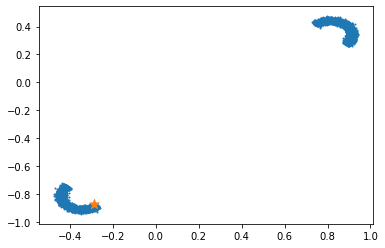

In [8]:
# load /work/dante/scripts/VMEval/dataset/sbibm_tasks/two_moons/files/num_observation_1/observation.csv as array
obs_loc='/work/dante/scripts/VMEval/dataset/sbibm_tasks/two_moons/files/num_observation_2/'

obs=np.loadtxt(os.path.join(obs_loc,'observation.csv'),delimiter=',',skiprows=1)

true_theta=np.loadtxt(os.path.join(obs_loc,'true_parameters.csv'),delimiter=',',skiprows=1)

ref_posterior=np.loadtxt(os.path.join(obs_loc,'reference_posterior_samples.csv'),delimiter=',',skiprows=1)


plt.scatter(ref_posterior[:,0],ref_posterior[:,1],s=1)

plt.scatter(true_theta[0],true_theta[1],marker='*',s=100)

### Set NF model

In [10]:
N_model=1
models=[]
for _ in range(N_model):
    model=get_conditional_ANSF(dim=2,num_layers=16,context_size=2)
    device = torch.device('cuda')
    model = model.to(device)
    models.append(model)

In [11]:
# train_set=TensorDataset(torch.tensor(samples,dtype=torch.float32),torch.tensor(thetas,dtype=torch.float32)) #NLE

#NPE
train_set=TensorDataset(torch.tensor(thetas,dtype=torch.float32),torch.tensor(samples,dtype=torch.float32))

/tmp/ipykernel_2116705/2975654075.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_set=TensorDataset(torch.tensor(thetas,dtype=torch.float32),torch.tensor(samples,dtype=torch.float32))


In [19]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)

### Train NF

In [20]:
losses=[]
for model in models:

    num_epoch = 100
    show_iter = 100

    loss_hist = np.array([])
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)

    batch_trained=0
    for epoch in range(num_epoch):
        
        for batch in tqdm(train_loader):
            optimizer.zero_grad()

            x = batch[0].to(device)
            theta = batch[1].to(device)
            
            # Compute loss
            loss = model.forward_kld(x,theta)
            
            # Do backprop and optimizer step
            if ~(torch.isnan(loss) | torch.isinf(loss)):
                loss.backward()
                optimizer.step()
            
            # Log loss
            loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
            
            # Plot learned distribution
            batch_trained+=1
    
    losses.append(loss_hist)    


100%|██████████| 79/79 [00:09<00:00,  8.06it/s]


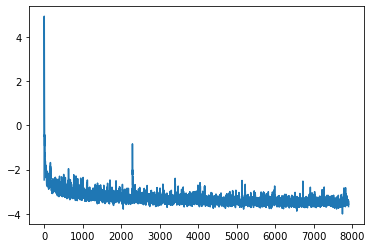

In [21]:
plt.plot(np.array(losses).T)

In [22]:
ens_nf=CondEnsembleModel(models)

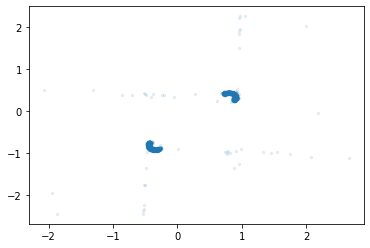

In [23]:
eval_samples=ens_nf.sample(10000,contexts=torch.tensor(np.repeat(obs[None,:],10000,axis=0),
                                                       dtype=torch.float32,device='cuda'),to_numpy=True)

plt.scatter(eval_samples[:,0],eval_samples[:,1],s=5,alpha=0.1)

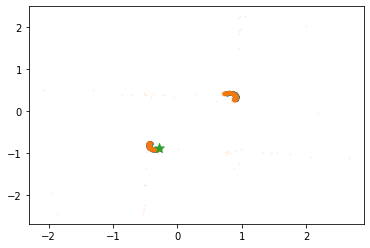

In [24]:

plt.scatter(ref_posterior[:,0],ref_posterior[:,1],s=1)


plt.scatter(eval_samples[:,0],eval_samples[:,1],s=1,alpha=0.1)
plt.scatter(true_theta[0],true_theta[1],marker='*',s=100)

# plt.xlim(-1,-0.5)
# plt.ylim(-0.75,-0.25)

In [25]:
np.save('nf_twomoon_pos.npy',eval_samples)

## BGLM

In [4]:
import sbibm
from sbibm.metrics import mmd

task = sbibm.get_task("bernoulli_glm")  # See sbibm.get_available_tasks() for all tasks
prior = task.get_prior()

simulator = task.get_simulator()

# These objects can then be used for custom inference algorithms, e.g.
# we might want to generate simulations by sampling from prior:
thetas = prior(num_samples=10000)
samples = simulator(thetas)

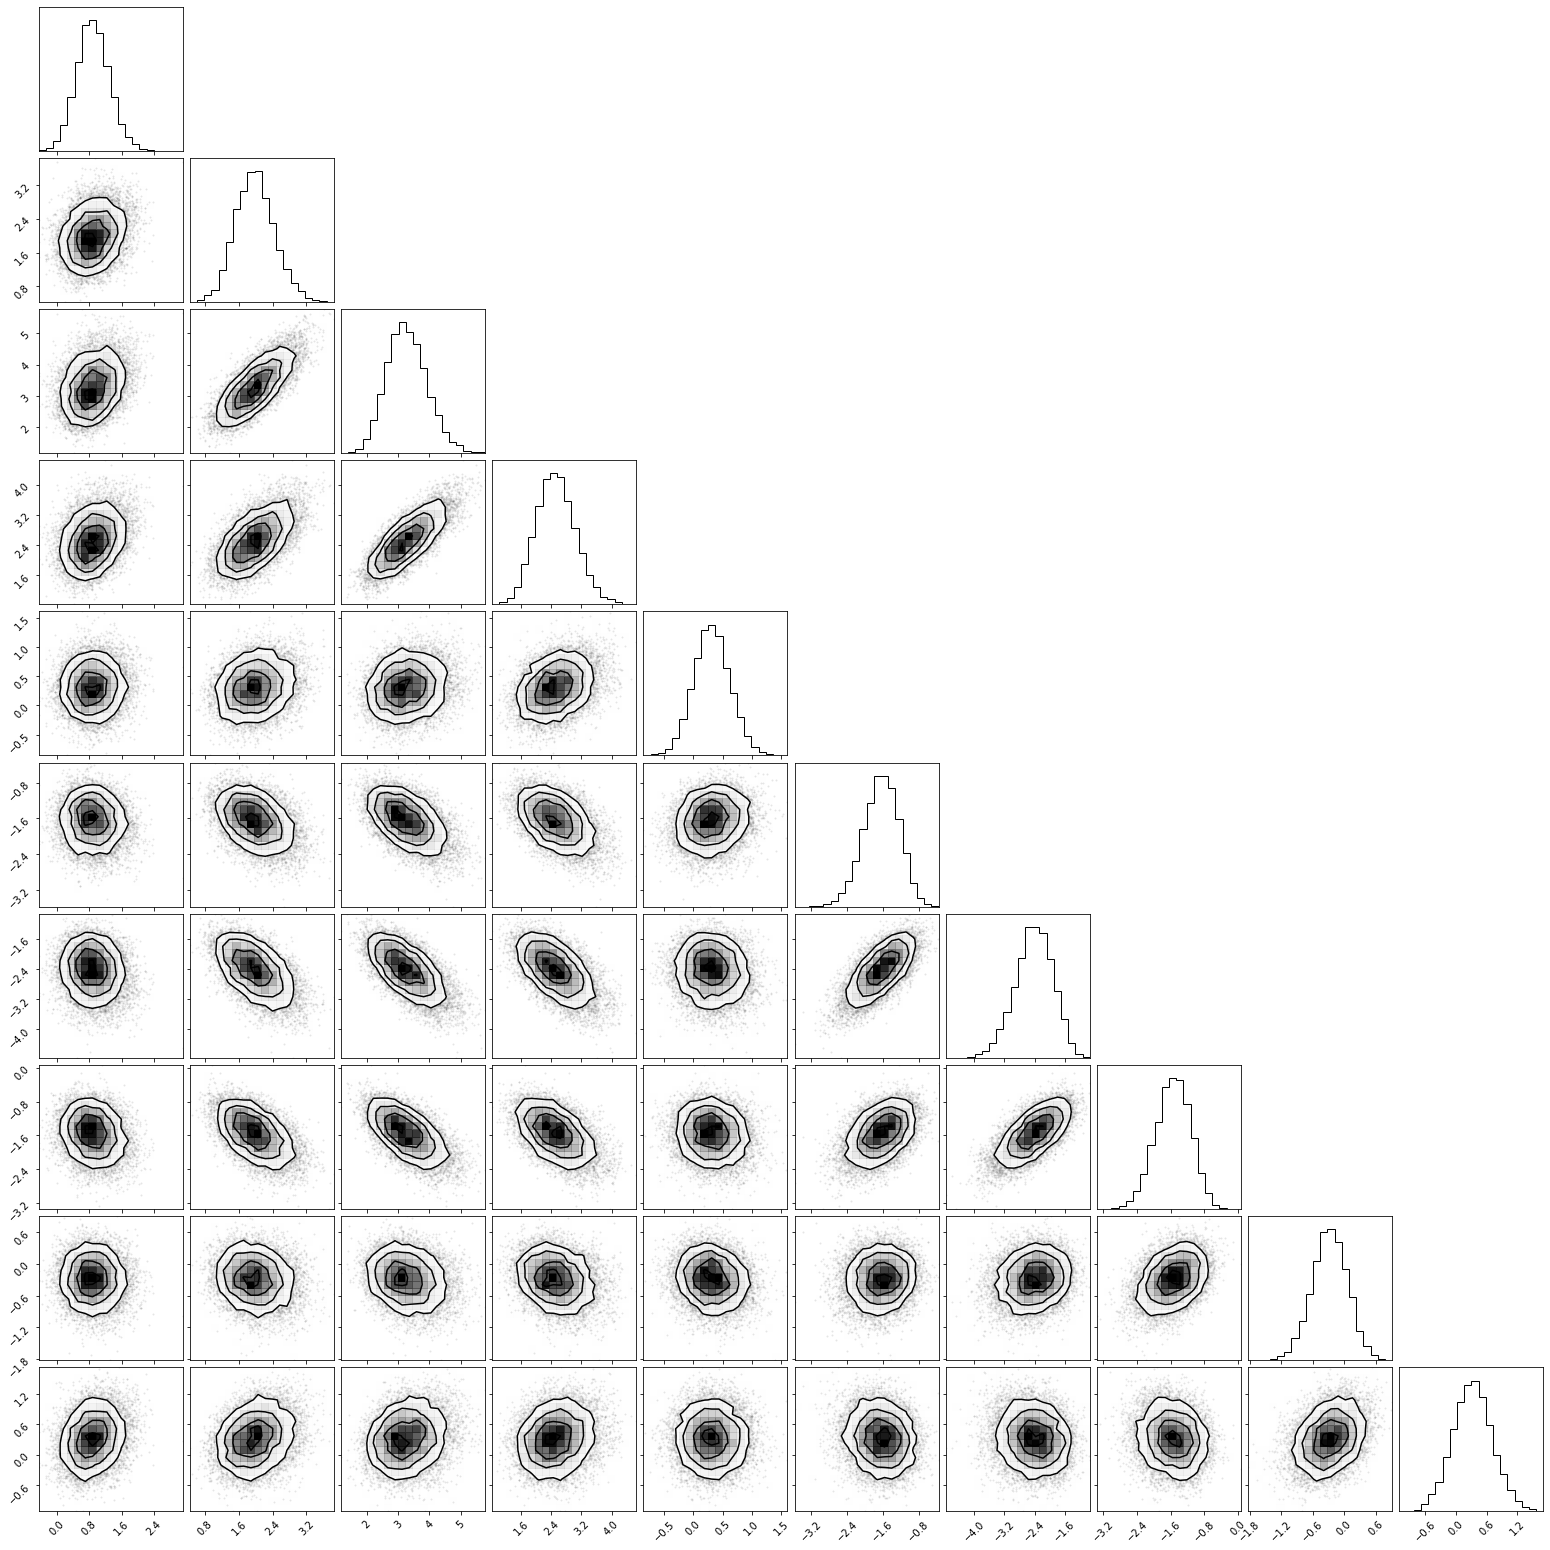

In [6]:
import os

obs_loc='/work/dante/scripts/VMEval/dataset/sbibm_tasks/bernoulli_glm/files/num_observation_1'

obs=np.loadtxt(os.path.join(obs_loc,'observation.csv'),delimiter=',',skiprows=1)

true_theta=np.loadtxt(os.path.join(obs_loc,'true_parameters.csv'),delimiter=',',skiprows=1)

ref_posterior=np.loadtxt(os.path.join(obs_loc,'reference_posterior_samples.csv'),delimiter=',',skiprows=1)

corner(ref_posterior);

In [20]:
N_model=5
models=[]
for _ in range(N_model):
    model=get_conditional_ANSF(dim=10,num_layers=16,context_size=10)
    model = model.to(device)
    models.append(model)



In [21]:
losses=[]

# batch = (torch.tensor(samples, dtype=torch.float32).to(device),torch.tensor(thetas, dtype=torch.float32).to(device)
dataset=torch.tensor(samples).float().to(device)
thetas=torch.tensor(thetas).float().to(device)
for model in models:

    num_epoch = 100
    batch_size=1000

    loss_hist = np.array([])
    batch_trained=0

    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)

    for epoch in range(num_epoch):
        
        permutation = torch.randperm(dataset.size()[0])

        for i in tqdm(range(0, dataset.size()[0], batch_size)):
            optimizer.zero_grad()

            indices = permutation[i:i+batch_size]
            batch_x = thetas[indices]
            batch_x_cond = dataset[indices]
            
            # Compute loss
            loss = model.forward_kld(batch_x,batch_x_cond)
            
            # Do backprop and optimizer step
            if ~(torch.isnan(loss) | torch.isinf(loss)):
                loss.backward()
                optimizer.step()
            
            # Log loss
            loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
            
            # Plot learned distribution
            batch_trained+=1
    
    losses.append(loss_hist)    


/tmp/ipykernel_3014208/3647768214.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset=torch.tensor(samples).float().to(device)
/tmp/ipykernel_3014208/3647768214.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  thetas=torch.tensor(thetas).float().to(device)
100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


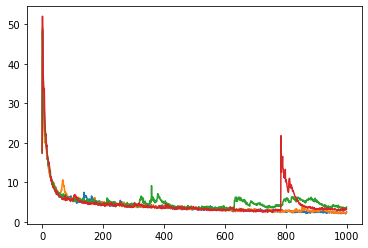

In [27]:
plt.plot(np.array(losses[1:]).T)

In [28]:
ens_nf=CondEnsembleModel(models[1:])

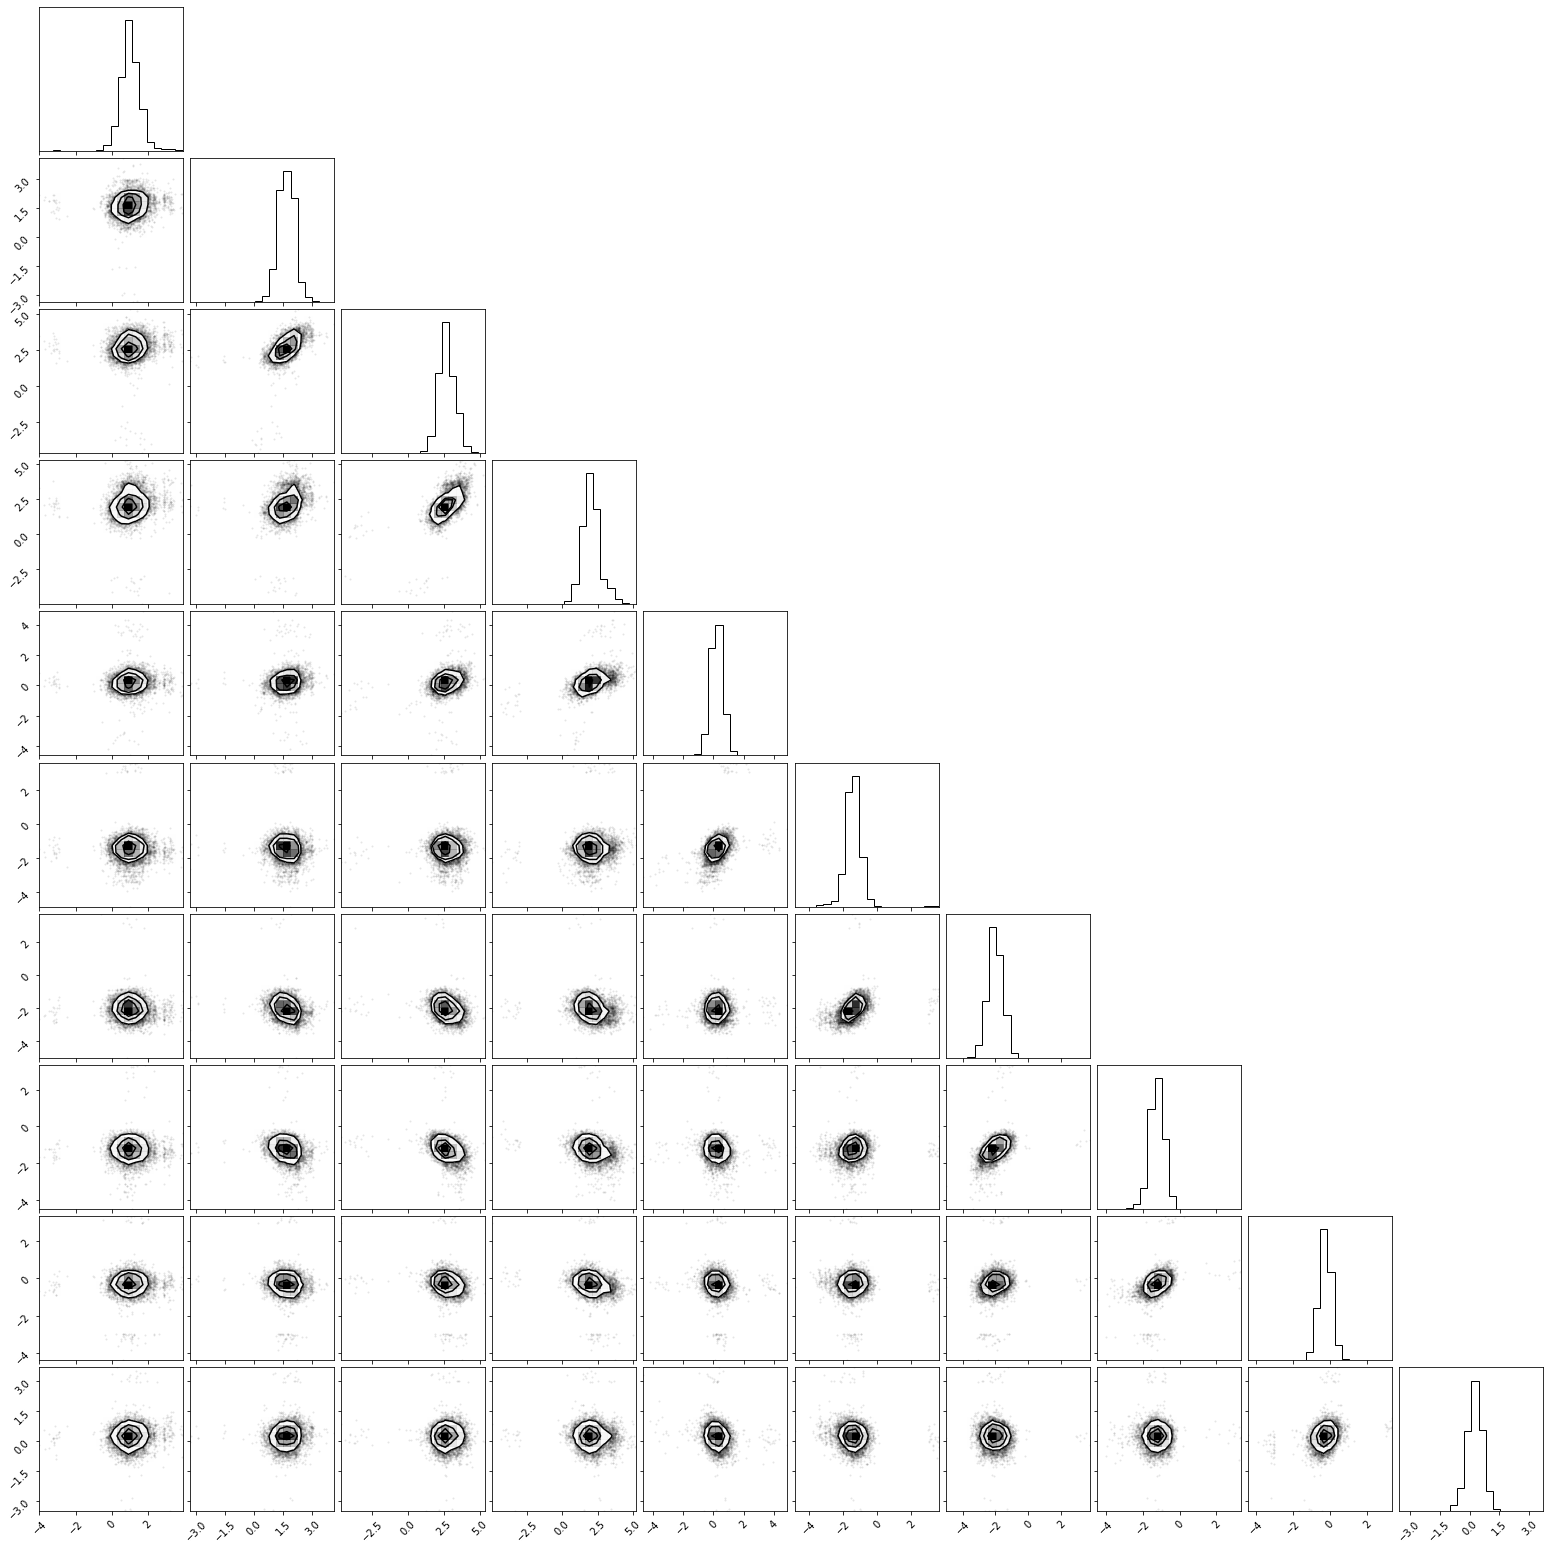

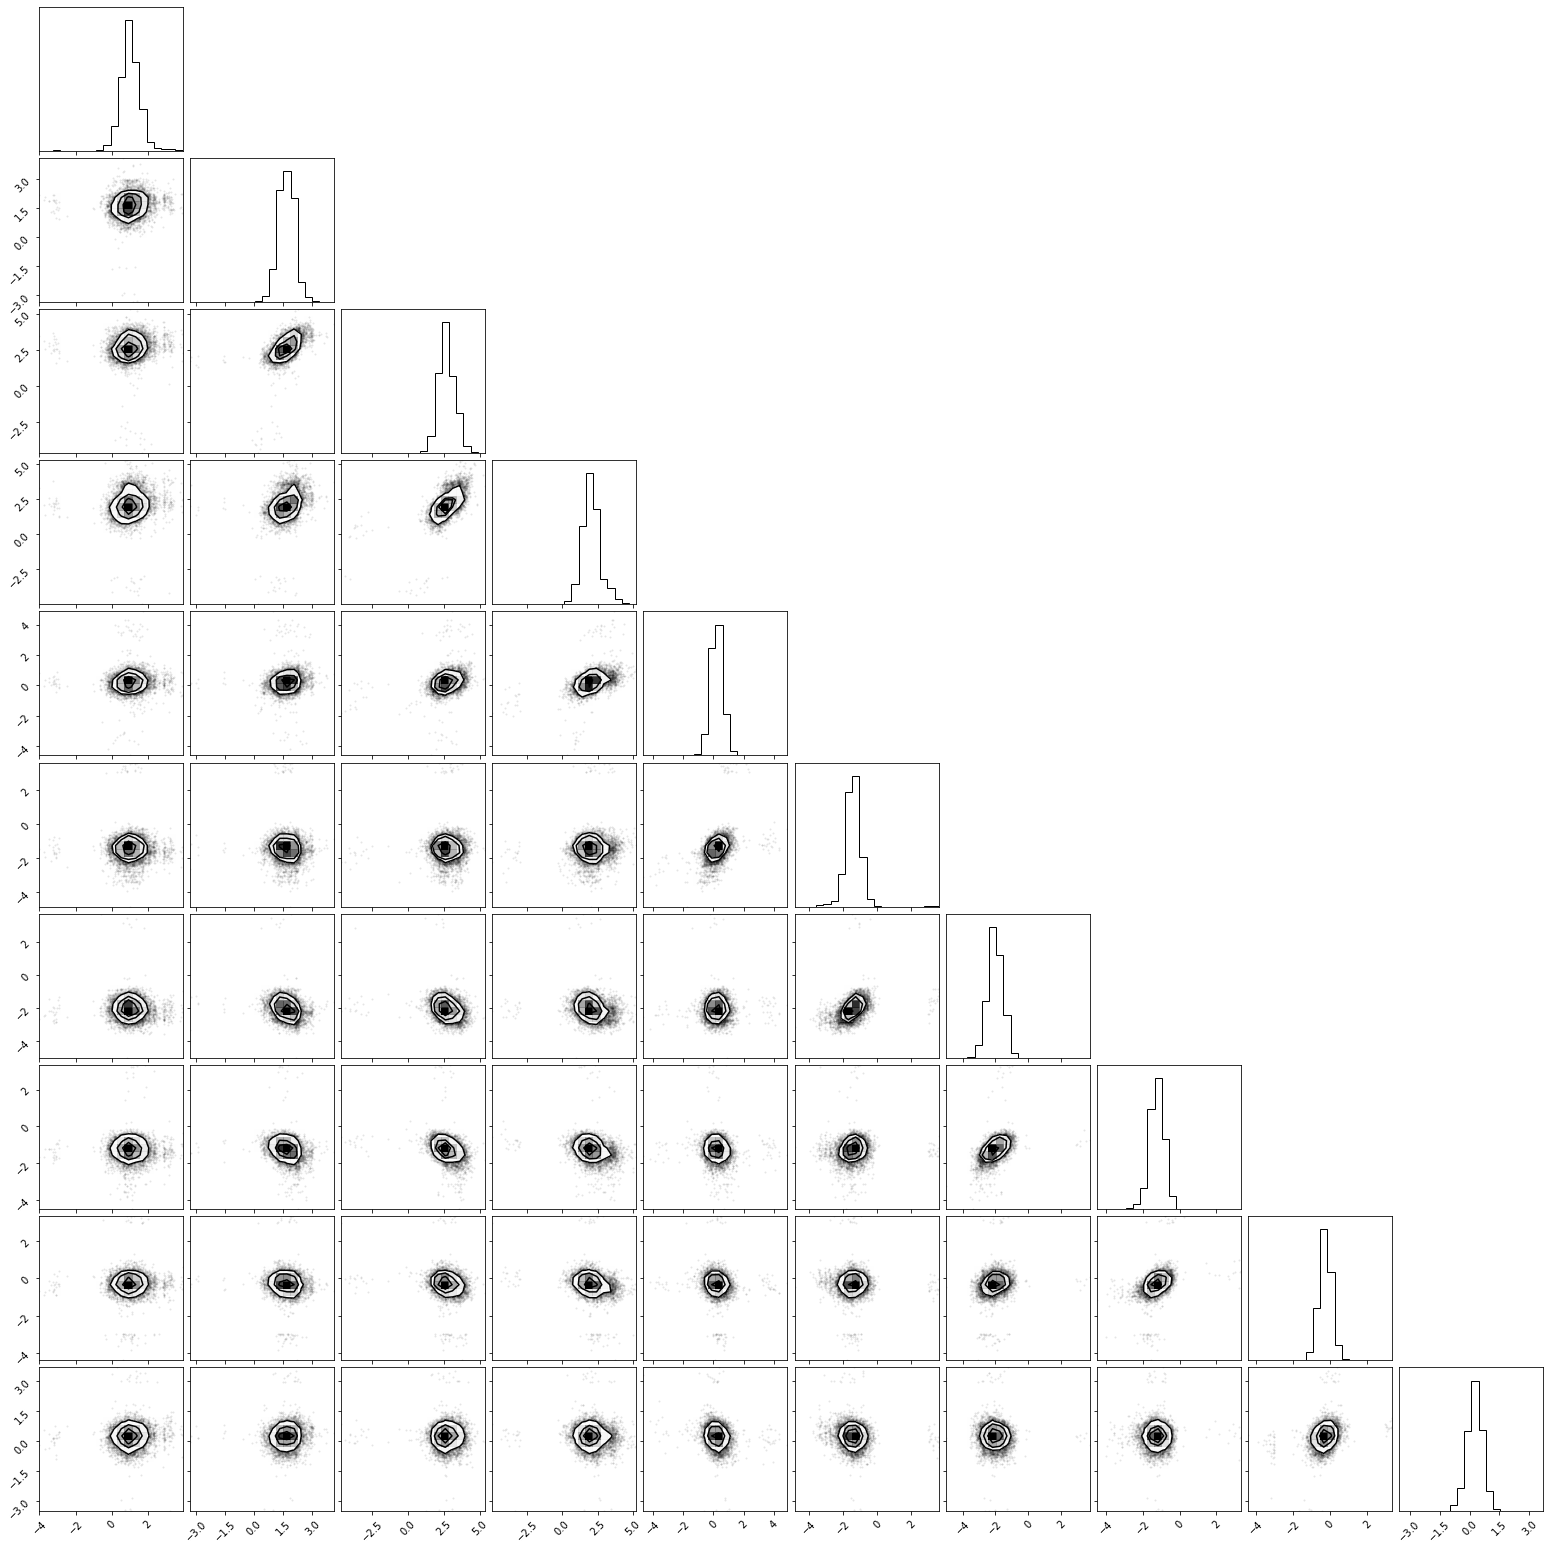

In [29]:
eval_samples=ens_nf.sample(10000,contexts=torch.tensor(np.repeat(obs[None,:],10000,axis=0),
                                                       dtype=torch.float32,device='cuda'),to_numpy=True)

corner(eval_samples)

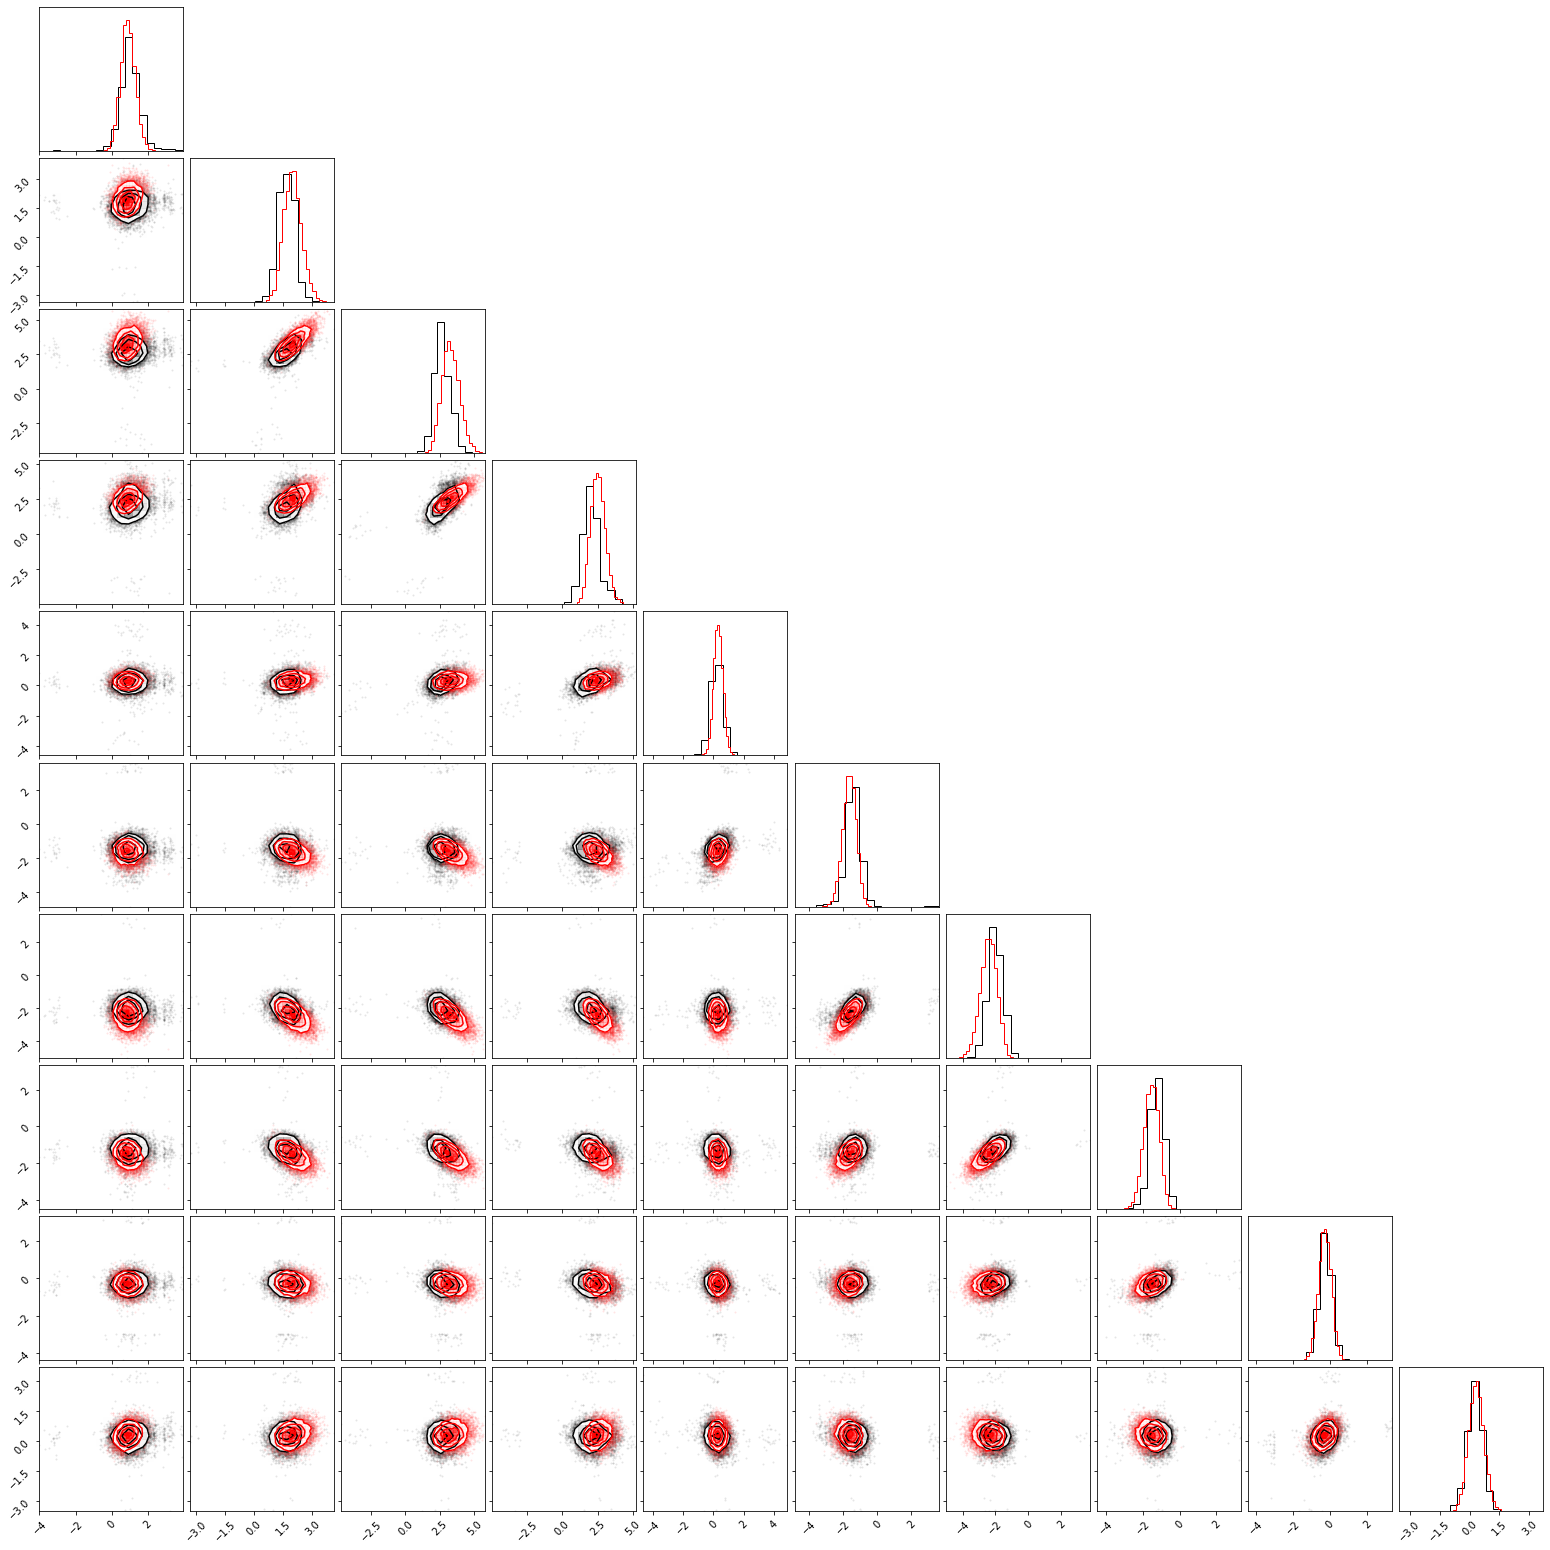

In [36]:
fig=corner(eval_samples,hist_kwargs={'density':True});
corner(ref_posterior,fig=fig,color='red',hist_kwargs={'density':True});

In [31]:
# np.save('nf_bglm_pos.npy',eval_samples)

## SLCP

In [38]:

task = sbibm.get_task("slcp")  # See sbibm.get_available_tasks() for all tasks
prior = task.get_prior()
simulator = task.get_simulator()

# These objects can then be used for custom inference algorithms, e.g.
# we might want to generate simulations by sampling from prior:
thetas = prior(num_samples=10000)
samples = simulator(thetas)

print(thetas.shape,samples.shape)

torch.Size([10000, 5]) torch.Size([10000, 8])


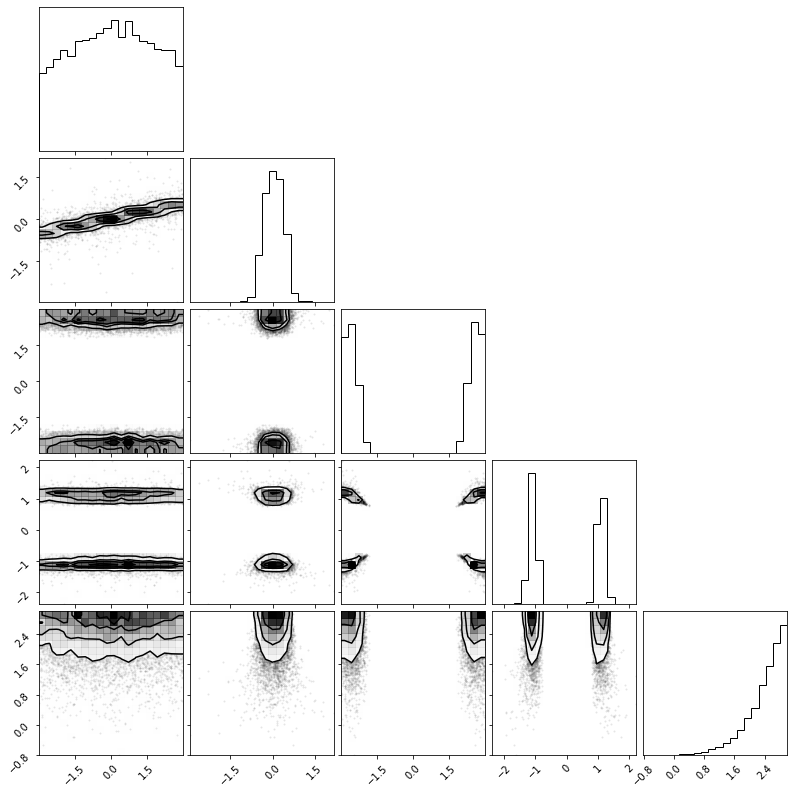

In [41]:
# load /work/dante/scripts/VMEval/dataset/sbibm_tasks/two_moons/files/num_observation_1/observation.csv as array
obs_loc='/work/dante/scripts/VMEval/dataset/sbibm_tasks/slcp/files/num_observation_1'

obs=np.loadtxt(os.path.join(obs_loc,'observation.csv'),delimiter=',',skiprows=1)

# obs_qt=qt.transform(obs.reshape(1,-1)).reshape(-1)

true_theta=np.loadtxt(os.path.join(obs_loc,'true_parameters.csv'),delimiter=',',skiprows=1)

ref_posterior=np.loadtxt(os.path.join(obs_loc,'reference_posterior_samples.csv'),delimiter=',',skiprows=1)

corner(ref_posterior);

In [42]:
N_model=5
models=[]
for _ in range(N_model):
    model=get_conditional_ANSF(dim=5,num_layers=16,context_size=8)
    model = model.to(device)
    models.append(model)

In [45]:
losses=[]

# batch = (torch.tensor(samples, dtype=torch.float32).to(device),torch.tensor(thetas, dtype=torch.float32).to(device)
dataset=torch.tensor(samples).float().to(device)
thetas=torch.tensor(thetas).float().to(device)
for model in models:

    num_epoch = 100
    batch_size=500

    loss_hist = np.array([])
    batch_trained=0

    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)

    for epoch in range(num_epoch):
        
        permutation = torch.randperm(dataset.size()[0])

        for i in tqdm(range(0, dataset.size()[0], batch_size)):
            optimizer.zero_grad()

            indices = permutation[i:i+batch_size]
            batch_x = thetas[indices]
            batch_x_cond = dataset[indices]
            
            # Compute loss
            loss = model.forward_kld(batch_x,batch_x_cond)
            
            # Do backprop and optimizer step
            if ~(torch.isnan(loss) | torch.isinf(loss)):
                loss.backward()
                optimizer.step()
            
            # Log loss
            loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
            
            # Plot learned distribution
            batch_trained+=1
    
    losses.append(loss_hist)    


/tmp/ipykernel_3014208/3342569841.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset=torch.tensor(samples).float().to(device)
/tmp/ipykernel_3014208/3342569841.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  thetas=torch.tensor(thetas).float().to(device)
100%|██████████| 20/20 [00:02<00:00,  8.29it/s]


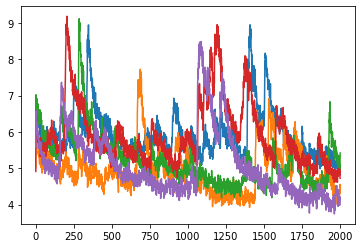

In [46]:
plt.plot(np.array(losses[:]).T)

In [47]:
ens_nf=CondEnsembleModel(models[:])

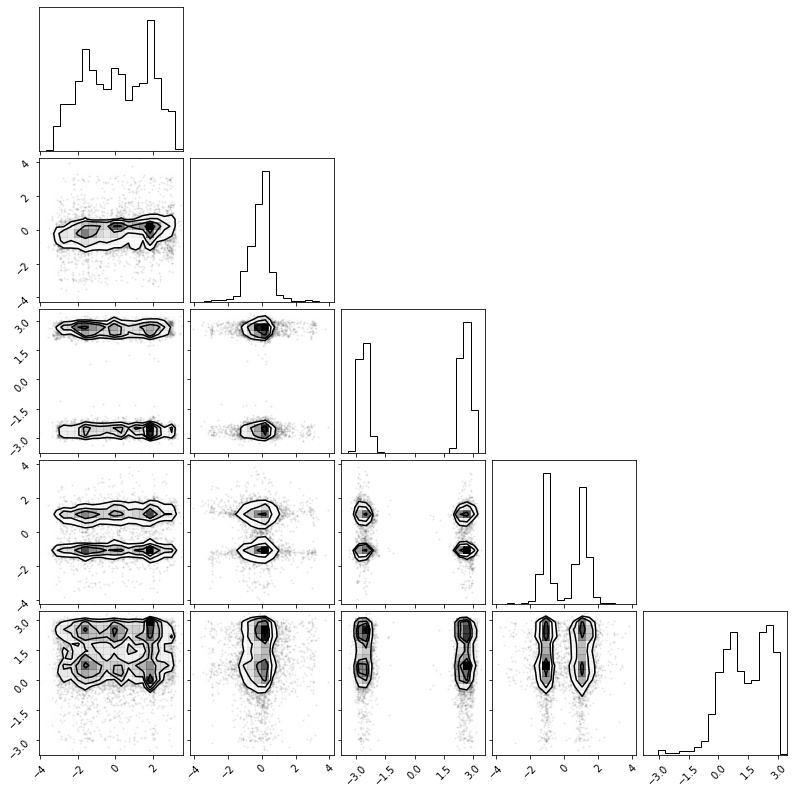

In [49]:
eval_samples=ens_nf.sample(10000,contexts=torch.tensor(np.repeat(obs[None,:],10000,axis=0),
                                                       dtype=torch.float32,device='cuda'),to_numpy=True)

corner(eval_samples);

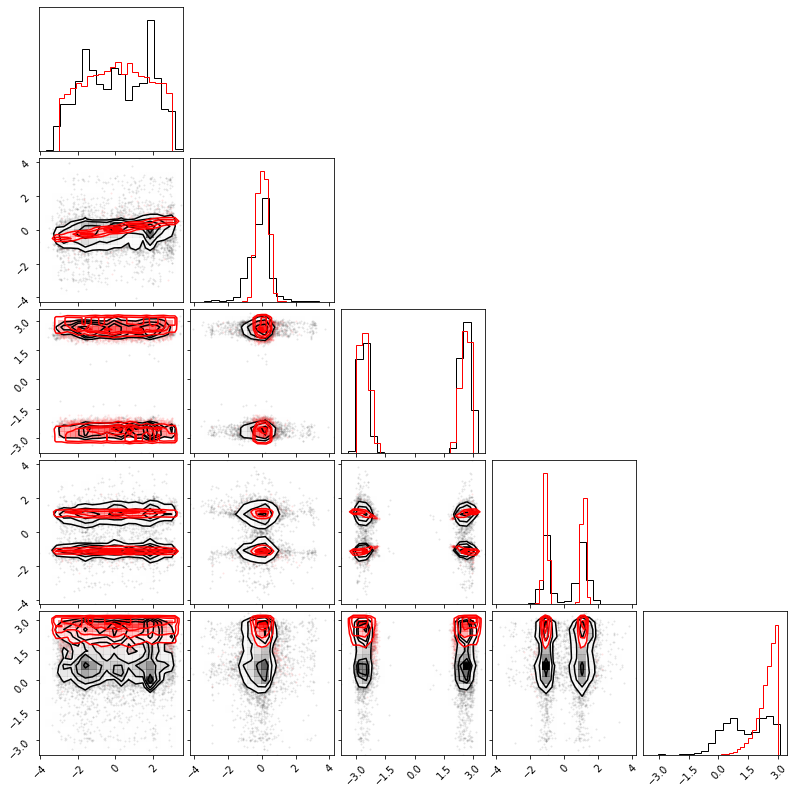

In [50]:
fig=corner(eval_samples,hist_kwargs={'density':True});
corner(ref_posterior,fig=fig,color='red',hist_kwargs={'density':True});

In [51]:
np.save('nf_sclp_pos.npy',eval_samples)

In [3]:
# Import required packages
import torch
import numpy as np
import normflows as nf
from matplotlib import pyplot as plt
from tqdm import tqdm

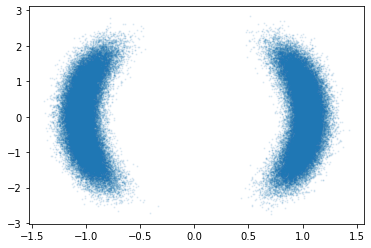

In [35]:
target = nf.distributions.TwoMoons()
data = target.sample(100000)

#normalize data
data_mean = data.mean(0)
data_std = data.std(0)
data = (data - data_mean) / data_std 

def true_likelihood(x):
    x = x * data_std + data_mean
    return target.log_prob(x).cpu().numpy()

plt.scatter(data[:,0], data[:,1], s=1, alpha=0.1)

In [36]:
def get_realNVP(dim=2,num_layers=32):
    base = nf.distributions.base.DiagGaussian(dim)

    flows = []
    for i in range(num_layers):
        # Neural network with two hidden layers having 64 units each
        # Last layer is initialized by zeros making training more stable
        param_map = nf.nets.MLP([1, 64, 64, dim], init_zeros=True)
        # Add flow layer
        flows.append(nf.flows.AffineCouplingBlock(param_map))
        # Swap dimensions
        flows.append(nf.flows.Permute(dim, mode='swap'))
        
    # Construct flow model
    model = nf.NormalizingFlow(base, flows)

    return model

In [37]:
nfm=get_realNVP()
device = 'cuda'
nfm = nfm.to(device)

In [38]:
dataset=torch.tensor(data).float().to(device)
epochs = 10
batch_size = 500
optimizer = torch.optim.Adam(nfm.parameters(), lr=5e-4, weight_decay=1e-5)

loss_hist = np.array([])
for epoch in range(epochs):

    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):

        optimizer.zero_grad()
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]

        # Compute loss
        loss = nfm.forward_kld(batch_x)
        
        # Do backprop and optimizer step
        if ~(torch.isnan(loss) | torch.isinf(loss)):
            loss.backward()
            optimizer.step()
        # Perform gradient clipping
        loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

    # if (epoch % 100 == 0):
    print(loss.item())


/tmp/ipykernel_2098452/3425557714.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset=torch.tensor(data).float().to(device)


1.1274619102478027
1.1663646697998047
1.1962820291519165
1.0683622360229492
1.150984525680542
1.058831810951233
1.1872994899749756
1.1498814821243286
1.1495678424835205
1.1274765729904175


In [39]:
samples = nfm.sample(10000)[0].cpu().detach().numpy()

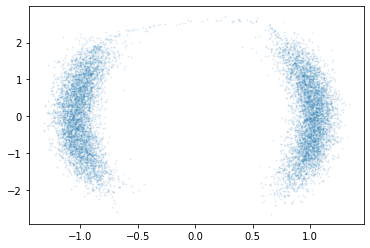

In [40]:
plt.scatter(samples[:,0], samples[:,1], s=1, alpha=0.1)

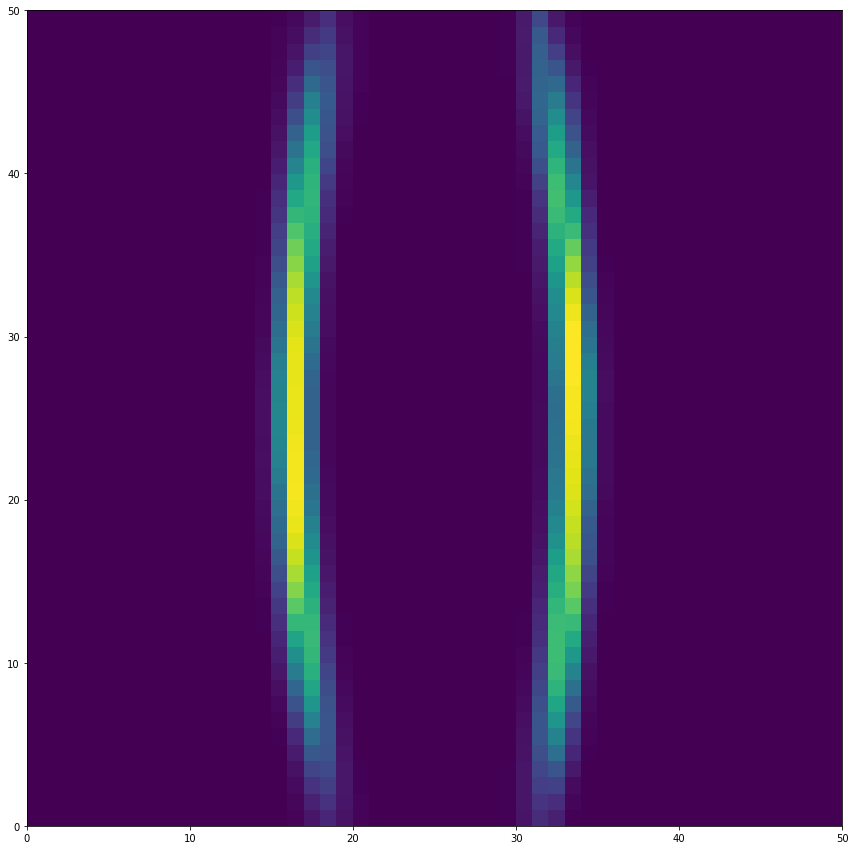

In [41]:
# Plot learned distribution
nfm.eval()

x0 = np.stack(np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-2, 2.0, 50)), axis=-1).reshape(-1, 2)
xx = torch.tensor(x0).float().to(device)
log_prob = nfm.log_prob(xx).to('cpu').view(50,50)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolor(prob.data.numpy())
plt.gca().set_aspect('equal', 'box')
plt.show()

In [42]:
np.save('nf_twomoon_prob.npy',prob.detach().numpy())